In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8    #Set the default size of plots to 14x8 inches for better readability
RANDOM_SEED = 42                      #Setting a random seed to ensure reproducibility of results
LABELS = ["Normal", "Fraud"]

In [2]:
file_path = "Dataset/credit_card_data.csv"
data = pd.read_csv(file_path)

Due to the long times it takes to calculate some of these Unsupervised Learning Models, we will work with a sample of the original data.

In [3]:
# We take a small sample of the data, to lower execution times before modelling
data_sample = data.sample(frac = 0.1, random_state = 1)
data_sample.shape

(28481, 31)

In [4]:
# Create independent and dependent features
columns = data_sample.columns.tolist()
# Filter the columns to remove data we don't want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting
target = "Class"
# Define a random state
state = np.random.RandomState(42)
X = data_sample[columns]
Y = data_sample[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# print the shapes of X and Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [5]:
# Defining the outlier detection methods
# We first create a dictionary named "classifiers"
classifiers = {
   "Isolation Forest": IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=(Y == 1).sum() / float(len(Y)), random_state=RANDOM_SEED, verbose=0),
   "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski', 
                                              p=2, contamination=(Y == 1).sum() / float(len(Y))),
   "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1)
}
type(classifiers)

dict

C:\Users\Christian Partal\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 72
Accuracy Score: 0.997471998876444
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.27      0.27      0.27        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

ROC AUC Score: 0.062234418246758474


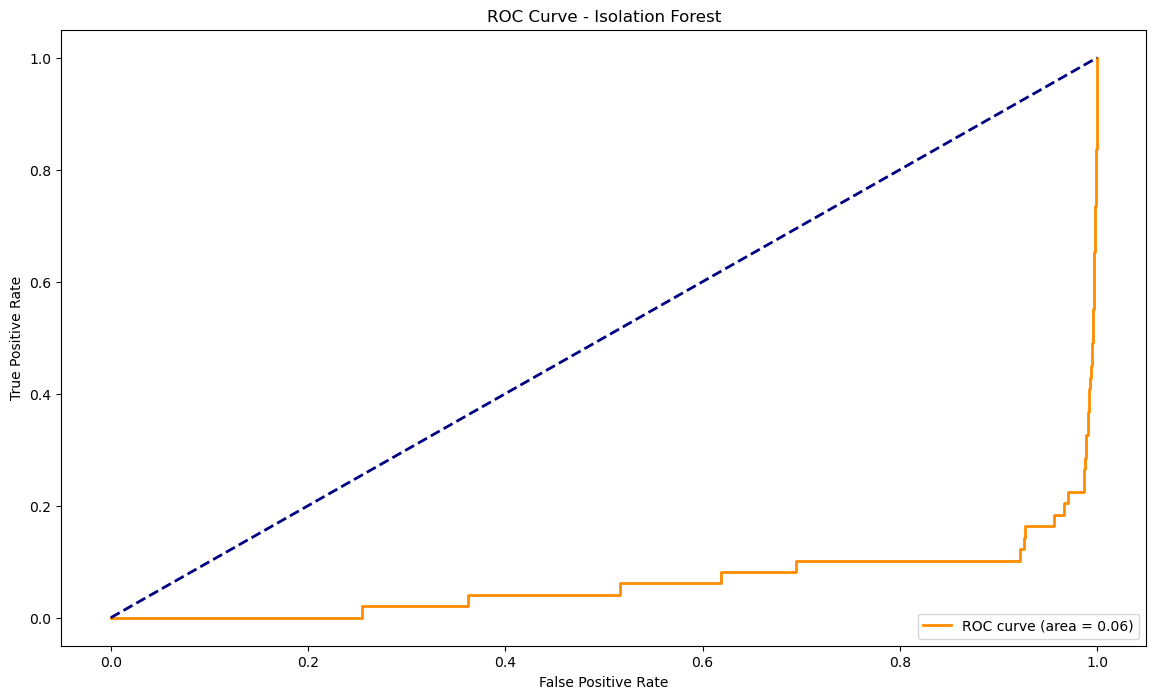

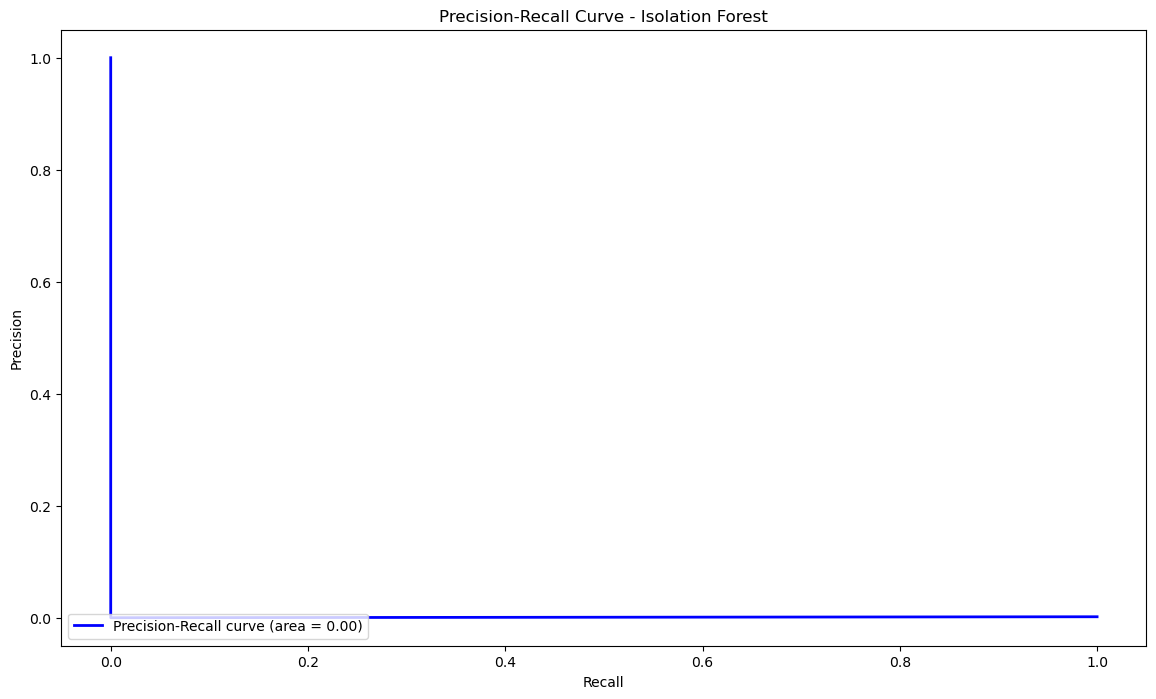

Local Outlier Factor: 96
Accuracy Score: 0.9966293318352586
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

ROC AUC Score: 0.41325956381427076


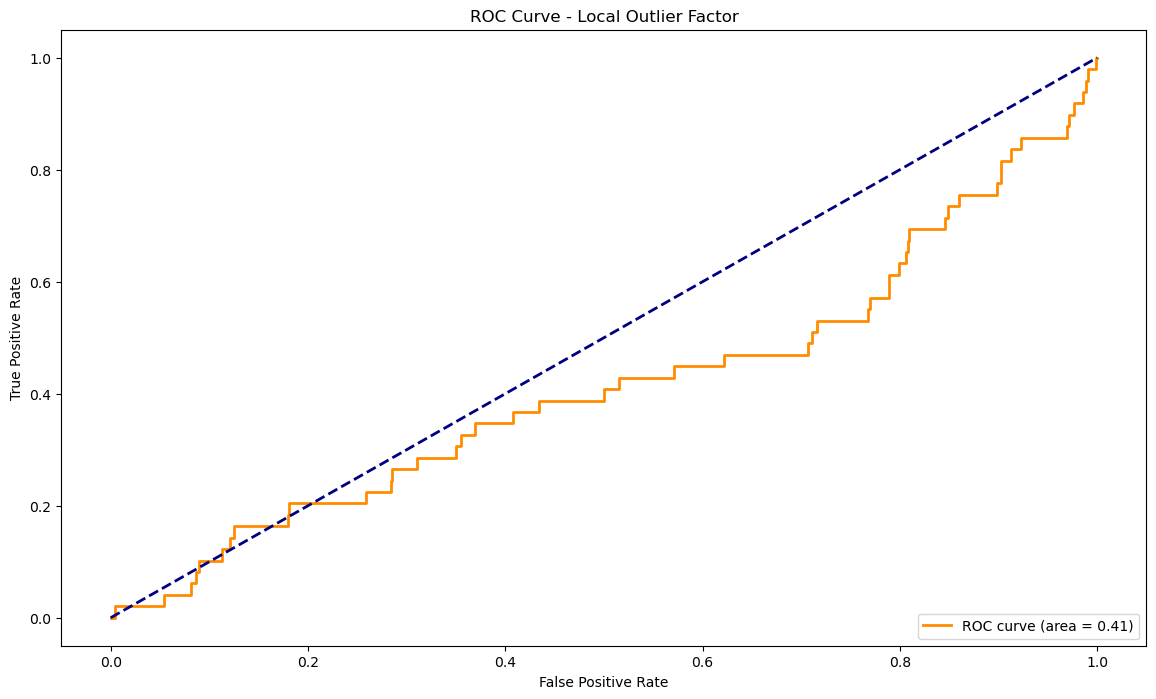

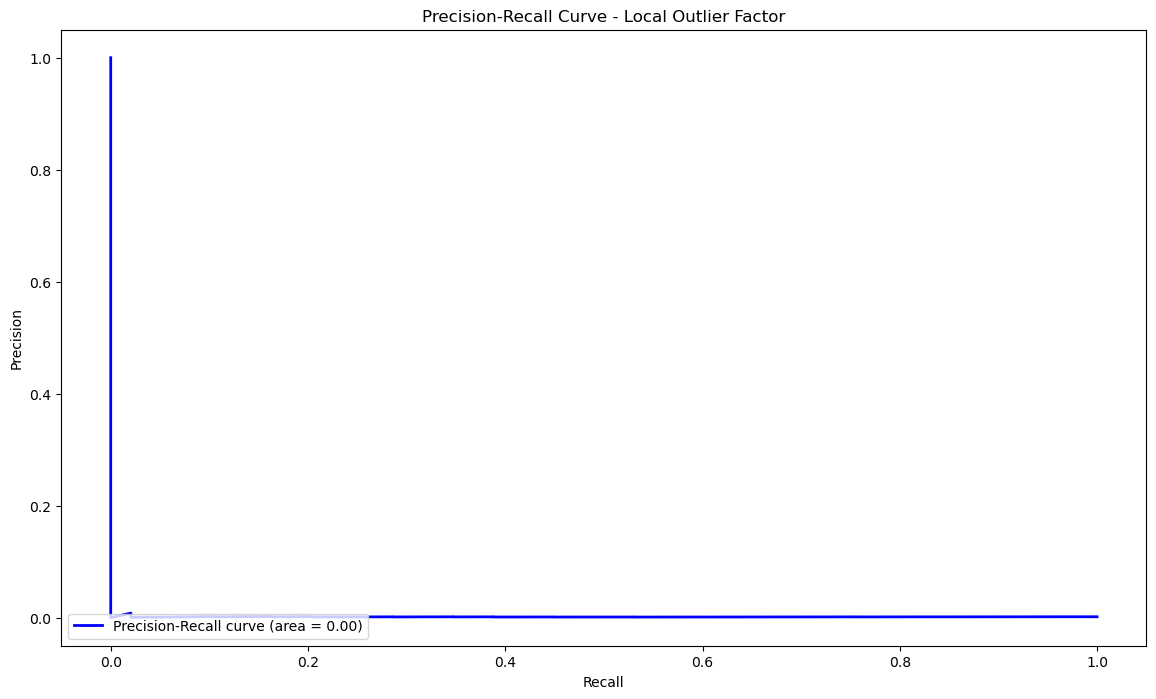

Support Vector Machine: 8516
Accuracy Score: 0.7009936448860644
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     28432
           1       0.00      0.37      0.00        49

    accuracy                           0.70     28481
   macro avg       0.50      0.53      0.41     28481
weighted avg       1.00      0.70      0.82     28481

ROC AUC Score: 0.41325956381427076


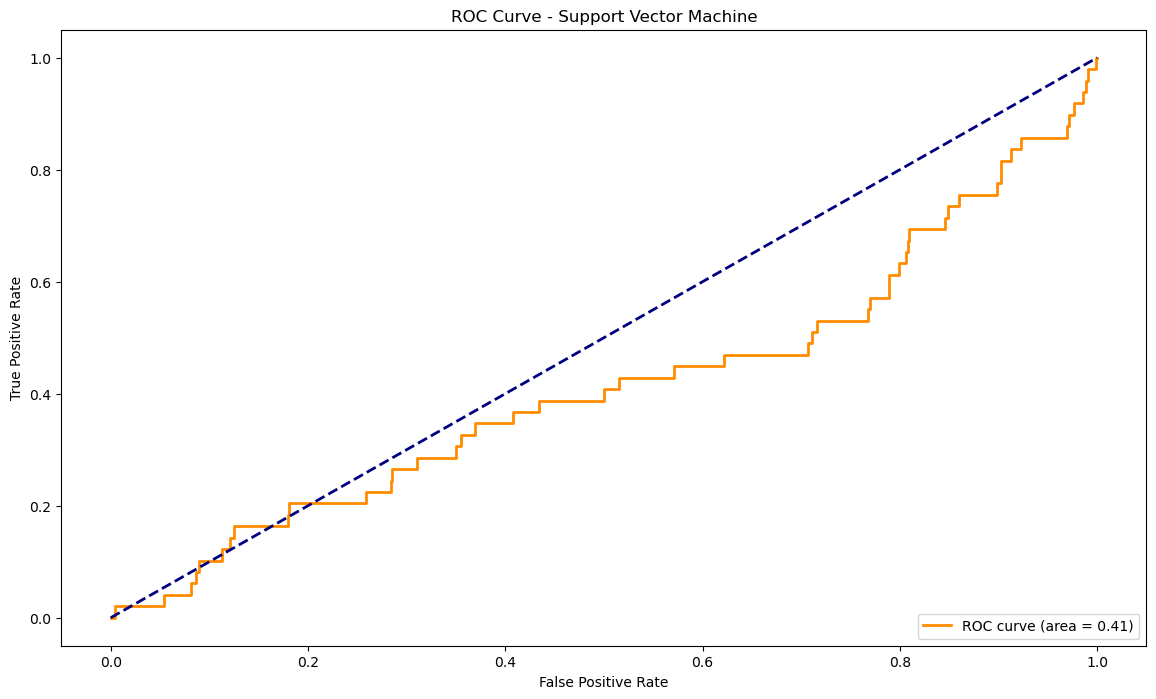

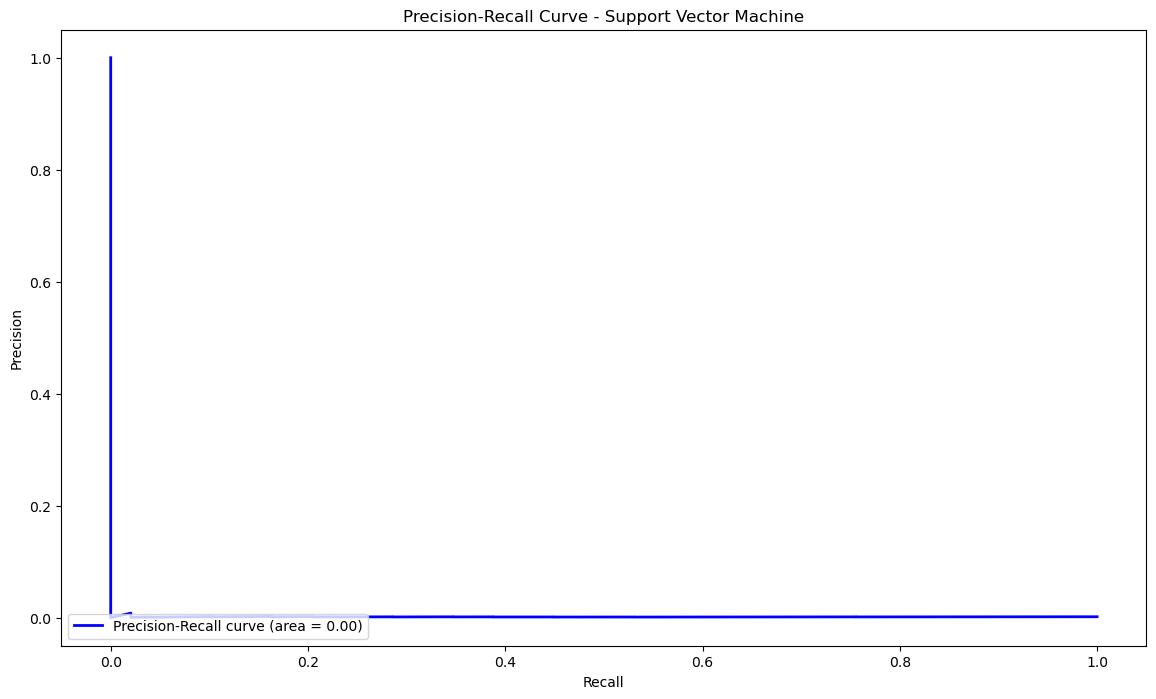

In [6]:
# We iterate over the different outlier detection algorithms, fitting the data, and predicting outliers
# Taking from the "classifiers" dictionary, "clf_name" is the key and "clf" is the value
# Since we are using a sample, it will be less time consuming than the entire dataset. But the SVM model might still take a few minutes
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

n_outliers = (Y == 1).sum()
for i, (clf_name, clf) in enumerate(classifiers.items()):
    # Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)       # "fit_predict" is used for LOF
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)                        # "fit" and then "predict" are used for SVM
        y_pred = clf.predict(X)
    else:         # Isolation Forest
        clf.fit(X)
        # Converting back to DataFrame to preserve feature names
        X_df = pd.DataFrame(X, columns=columns)
        scores_prediction = clf.decision_function(X_df)  # "decision_function" is used for Isolation Forest
        y_pred = clf.predict(X_df)

    # Reshape the prediction values to 0 for Valid transactions, 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    accuracy = accuracy_score(Y, y_pred)
    report = classification_report(Y, y_pred)
    
    print(f"{clf_name}: {n_errors}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Classification Report:\n{report}")
  
    # ROC AUC Score
    roc_auc = roc_auc_score(Y, scores_prediction)
    print(f"ROC AUC Score: {roc_auc}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(Y, scores_prediction)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {clf_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y, scores_prediction)
    average_precision = average_precision_score(Y, scores_prediction)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {clf_name}')
    plt.legend(loc="lower left")
    plt.show()

By looking at the results, we see that the Unsupervised Learning models perform worse than the Supervised Learning models 
seen in part 2 of the project.
The low precision, the ROC AUC Score and the shapes of the curves tell us that these models are unreliable for fraud detection.

Therefore, we continue to recommend the basic Linear Regression model at a threshold of 0.07 or 0.08.